In [1]:
# jupyter notebook go wide screen
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from hetdex_api.shot import *
from hetdex_api.extract import Extract
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from astropy.table import Table, join, vstack
import numpy as np
from scipy.integrate import quad
import glob
import logging

from astropy.io import ascii, fits
from astropy.modeling.functional_models import Moffat1D
from astropy.stats import biweight_scale
from astropy import units as u
from astropy.coordinates import SkyCoord
import time
import multiprocessing

# import my own utils : get_ffss, get_xrt_time
from tools_2d import *
from weighted_biweight import *

In [4]:
logger = logging.Logger('catch_all')

In [5]:
def load_shot(shot):
        fileh = open_shot_file(shot)
        table = Table(fileh.root.Data.Fibers.read())
        return table

In [6]:
def efunc(z, om, ol):
	return (om*(1+z)**3+ol)**(-1./2)

def integral(z, omega_m, omega_lambda):
	return quad(efunc, 0, z, args=(omega_m, omega_lambda))

def DA(z, h=0.674, omega_m=0.315, omega_lambda=0.685):
	Dh = 3000 * 1/h * u.Mpc 
	return Dh/(1+z)*integral(z, omega_m, omega_lambda)

def kpc_proper_per_deg(z, h=0.674, omega_m=0.315, omega_lambda=0.685):
	return np.pi/(648000)*3600*DA(z, h=0.674, omega_m=0.315, omega_lambda=0.685).to(u.kpc)


In [7]:
def_wave = np.arange(3470., 5542., 2.)

In [8]:
PSF = False
TEST = False

In [9]:
if PSF:
    laetab = ascii.read("/data/05865/maja_n/im2d/stars.cat")
    print("Opened star catalog for PSF.")
elif TEST:
    laetab = ascii.read("/data/05865/maja_n/im2d/testlaes.cat")
    print("Opened test LAE catalog for intensity mapping")
else:
    laetab = ascii.read("/data/05865/maja_n/im2d/goodlaes.cat")
    print("Opened LAE catalog for intensity mapping")

Opened LAE catalog for intensity mapping


In [10]:
if PSF:
    laetab["shotid"]= [int(x[:-4]+x[-3:]) for x in laetab["shot"]]
    laetab = laetab[(laetab["gmag"]>19.)&(laetab["gmag"]<=20.)]
    laetab["ifuslot"] = "164"

In [11]:
order = np.argsort(laetab["shotid"])
laetab = laetab[order]

shots_raw = np.unique(laetab["shotid"])
shots_raw = [str(x)[:-3]+"v"+str(x)[-3:] for x in shots_raw]
bads = ascii.read("/data/05865/maja_n/im2d/badifus.dat")
badshots = bads["shot"][bads["ifuamp"]=="alle"]

laenumber = 0
shotlist = []
for shot in shots_raw:
    if shot in badshots:
        print("oh no.")
        continue
    elif shot == "20180110v007":
        print("oh no.")
        continue
    else:
        shotlist.append(shot)
        lae = laetab[laetab["shotid"]==int(shot[:-4]+shot[-3:])]
        for i in range(len(lae)):
            ifu = str(lae["ifuslot"][i])
            if len(ifu)==2:
                ifu = "0"+ifu
            if ifu+"AA" in bads[bads["shot"]==shot]:
                continue
            else:
                laenumber += 1

oh no.
oh no.
oh no.
oh no.


In [12]:
laenumber

429

In [19]:
KPC = True
shotlist = np.sort(shotlist)
#distances = np.arange(0, 50., 3.)*1./3600.
distances = np.arange(0, 50., 1.5)*1./3600. # Change this!!!
if KPC:
	distances = kpc_proper_per_deg(2.5)[0]*distances
	print("distances in proper kpc: ", distances)


distances in proper kpc:  [  0.          12.41285038  24.82570076  37.23855115  49.65140153
  62.06425191  74.47710229  86.88995268  99.30280306 111.71565344
 124.12850382 136.5413542  148.95420459 161.36705497 173.77990535
 186.19275573 198.60560612 211.0184565  223.43130688 235.84415726
 248.25700764 260.66985803 273.08270841 285.49555879 297.90840917
 310.32125955 322.73410994 335.14696032 347.5598107  359.97266108
 372.38551147 384.79836185 397.21121223 409.62406261] kpc


In [20]:
len(shotlist)

144

In [30]:
RANDOM = False
CONTINUUMCUT = 5.

In [60]:
def imfunc(idx):
    st = time.time()
    # get ffss, weights, etc
    shot = shotlist[idx]
    
    with open(f"/data/00115/gebhardt/detect/{shot}/fwhm.out") as ffile:
        shot_fwhm = ffile.readlines()[0].strip()
        shot_fwhm = float(shot_fwhm.split(" ")[0])
    shot_gamma = shot_fwhm/(2.*np.sqrt(2**(1/3.9)-1))
    
    laecount = 0
            
    shotid = int(shot[:-4]+shot[-3:])
    tmptab = laetab[laetab["shotid"]==shotid]
    #print(f"{len(tmptab)} LAEs in shot {shotid}")
    

    try:
        xrt = get_xrt_time(shot)
        shot_table_0 = load_shot(shot)
        
            # get IFUs and amps for the LAEs in this shot to speed up the process
        # and get rid of bad amps
        ifuamps = []
        for counter in range(len(tmptab)):
            if PSF:
                ifu0 = shot_table_0["ifuslot"][(shot_table_0["ra"]-tmptab["ra"][counter] < 2./3600.)&(shot_table_0["dec"]-tmptab["dec"][counter] < 2./3600.)][0]
            else:
                ifu0 = str(tmptab["ifuslot"][counter])
            if len(ifu0)==2:
                ifu0 = "0"+ifu0
            for amp0 in ["LL","LU","RL","RU"]:
                if (ifu0, amp0) in ifuamps:
                    print(ifuamps)
                    print("we had this one already")
                elif ifu0+amp0 in bads["ifuamp"][bads["shot"]==shot]:
                    print("bad one")
                elif ifu0+"AA" in bads["ifuamp"][bads["shot"]==shot]:
                    print("bad one")
                else:
                    ifuamps.append((ifu0, amp0))
        
        shot_table = shot_table_0[:0]
        shothere = []
        # only use part of the shot table that we need
        ffpath = "/work/05865/maja_n/stampede2/ffskysub/{}/".format(shot)
        for ifu, amp in ifuamps:
            if len(shot_table[(shot_table["ifuslot"]==ifu)&(shot_table["amp"]==amp)])>0:
                print("added this one already")
            else:
                for expnum in [1,2,3]:
                    shot_tmp = shot_table_0[(shot_table_0["ifuslot"]==ifu)&(shot_table_0["amp"]==amp)&(shot_table_0["expnum"]==expnum)]
                    multi = shot_tmp["multiframe"][0]
                    
                    # get my own ffskysub
                    filename = ffpath+"exp0"+str(expnum)+"/"+multi+".fits"
                    try:
                        ffss = fits.getdata(filename)
                    except Exception as e:
                        print(multi, e)
                        print("Adding zeros!!!")
                        ffss = np.zeros((112,1036))
                    shot_tmp["ffss"] = ffss
                    shothere.append(shot_tmp)
                    
        if len(shothere)>0:        
            shot_table = vstack(shothere)
        else:
            print(f"no good amps in shot {shot}.")
            return 0
        shot_table["spec_fullsky_sub"] # test if it exists, otherwise end imfunc
        shot_table_0 = None
        
        if False:
            # mask sky lines
            line = 3910
            here1 = np.where((def_wave>line-7)&(def_wave<line+7))[0]
            line = 4359
            here2 = np.where((def_wave>line-7)&(def_wave<line+7))[0]
            line = 5461
            here3 = np.where((def_wave>line-7)&(def_wave<line+7))[0]
            shot_table["spec_fullsky_sub"][here1] = np.nan
            shot_table["spec_fullsky_sub"][here2] = np.nan
            shot_table["spec_fullsky_sub"][here3] = np.nan
            shot_table["calfib"][here1] = np.nan
            shot_table["calfib"][here2] = np.nan
            shot_table["calfib"][here3] = np.nan
            
        # take out continuum sources
        wlhere_l = (def_wave > 3800.)&(def_wave <= 4500.)
        wlhere_u = (def_wave > 4500.)&(def_wave <= 5200.)
        maxim_l, maxim_u = CONTINUUMCUT, CONTINUUMCUT
        min_l, min_u = -1*maxim_l, -1*maxim_u

        meanmean_l = np.nanmedian(shot_table["spec_fullsky_sub"][:,wlhere_l], axis=1)
        meanmean_u = np.nanmedian(shot_table["spec_fullsky_sub"][:,wlhere_u], axis=1)
        
        flag1 = (meanmean_l <=  maxim_l) & (meanmean_l > min_l)
        flag2 = (meanmean_u <= maxim_u) & (meanmean_u > min_u)
        flag1 = flag1*flag2
        
        # take out egde fibers: 
        flag2 = (abs(shot_table["ifux"]) <= 22)&(abs(shot_table["ifuy"]) <= 22)
        flag1 = flag1*flag2
        
        shot_table = shot_table[flag1]
        
        f2f = np.array([np.interp(def_wave, x, y) for x, y in zip(shot_table["wavelength"], shot_table["fiber_to_fiber"])])
        skysub = np.array([np.interp(def_wave, x, y) for x, y in zip(shot_table["wavelength"], shot_table["sky_subtracted"])])
        
        for i in range(len(shot_table)):
            ifu, amp = shot_table["ifuslot"][i], shot_table["amp"][i]
            shot_table["spec_fullsky_sub"][i] = shot_table["spec_fullsky_sub"][i]/(f2f[i] * xrt[(ifu, amp)](def_wave)) 
            shot_table["calfib"][i] = shot_table["calfib"][i]/(f2f[i] * xrt[(ifu, amp)](def_wave)) 
            
            gain = shot_table["calfib"][i] / skysub[i]
            gain[~np.isfinite(gain)] = 0.
            biscale = biweight_scale(gain[np.isfinite(gain)])
            biloc = biweight_location(gain[np.isfinite(gain)])
            these = abs(gain-biloc) > 6*biscale
            gain[these] = 0.
            shot_table["ffss"][i] = shot_table["ffss"][i]*gain/(f2f[i] * xrt[(ifu, amp)](def_wave)) 
        
        shot_table["spec_fullsky_sub"][shot_table["spec_fullsky_sub"]==0.0] = np.nan
        shot_table["calfib"][shot_table["spec_fullsky_sub"]==0.0] = np.nan
        shot_table["ffss"][shot_table["spec_fullsky_sub"]==0.0] = np.nan
        
        weights = shot_table["calfibe"]**(-2)
        weights[~np.isfinite(weights)] = 0.0
        weights[~np.isfinite(shot_table["spec_fullsky_sub"])] = 0.0
        weights[~np.isfinite(shot_table["calfib"])] = 0.0
        weights[~np.isfinite(shot_table["ffss"])] = 0.0
        #weights[weights>1.] = 0.0
        
        """#E = Extract()
        #E.load_shot(shot, survey="hdr2")
        #psffile = fits.open("/data/05865/maja_n/im2d/psf_hdr2/{}.fits".format(shot))
        #psf = np.array([psffile[0].data, psffile[1].data, psffile[2].data])
        #psffile.close()"""
        
        imlist, weightlist = [[] for i in range(len(distances)-1)], [[] for i in range(len(distances)-1)] # ffskysub HDR2, weights
        callist =  [[] for i in range(len(distances)-1)] # local skysub
        fflist = [[] for i in range(len(distances)-1)]   # "my" ffskysub
        moflist = [[] for i in range(len(distances)-1)]  # moffat function for psf4
        psflist = [[] for i in range(len(distances)-1)]  # star psf for each shot and LAE individually
        # loop through LAEs in this shot

        for lae_idx in range(len(tmptab)):
                
            if RANDOM:
                
                if PSF:
                    wave, ralae, declae = 4500., tmptab["ra"][lae_idx], tmptab["dec"][lae_idx]
                    lae_coords = SkyCoord(ralae*u.deg, declae*u.deg)
                    ifu = shot_table["ifuslot"][(shot_table["ra"]-ralae < 2./3600.)&(shot_table["dec"]-declae < 2./3600.)][0]
                else:
                    ralae, declae = tmptab["ra"][lae_idx], tmptab["dec"][lae_idx]
                    ifu = shot_table["ifuslot"][(shot_table["ra"]-ralae < 2./3600.)&(shot_table["dec"]-declae < 2./3600.)][0]
                    
                idxs = np.where(shot_table["ifuslot"]==ifu)[0]
                print("len idxs: {}".format(len(idxs))) 
                
                for iternum in range(20):
                    diff0 = random.randint(0, len(idxs)-1)
                    diff1 = idxs[diff0]
                    lae_fibnum, ralae, declae = shot_table["fibnum"][diff1], shot_table["ra"][diff1], shot_table["dec"][diff1]
                    lae_coords = SkyCoord(ralae*u.deg, declae*u.deg)
                    if not PSF:
                        wave = def_wave[random.randint(0, 1035)]
                    zlae = wave/1215.67 - 1

                    # get the weights for the psf
                    info_result = E.get_fiberinfo_for_coord(lae_coords, radius=5., ffsky=True)
                    xc, yc = info_result[2], info_result[3]
                    psf_weights = E.build_weights(xc, yc, shot_table["ifux"], shot_table["ifuy"], psf)
                    psf_weights[psf_weights<0.] = 0.
                    
                    #radiff, decdiff = shot_table["ra"] - ralae, shot_table["dec"] - declae
                    #diff = np.sqrt(radiff**2+decdiff**2)
                    all_coords = SkyCoord(shot_table["ra"]*u.deg, shot_table["dec"]*u.deg)
                    diff = lae_coords.separation(all_coords).deg
                    #print("diff: ", diff)
                    if KPC:
                        diff = kpc_proper_per_deg(zlae)[0]*diff 
                        #print("diff: ", diff)

                    # get lae flux for moffat amplitude
                    mindiff = diffdeg <= 2./3600
                    tmplaeweights = []
                    for hereidx in np.where(mindiff)[0]:
                        tmplaeweights.append(shot_table["spec_fullsky_sub"][hereidx][(abs(def_wave - wave) <= 2.5)]/psf_weights[hereidx][(abs(def_wave - wave) <= 2.5)])
                    if len(tmplaeweights)==0:
                        mindiff = diffdeg <= 4./3600
                        tmplaeflux = []
                        tmplaeweights = []
                        for hereidx in np.where(mindiff)[0]:
                            tmplaeweights.append(shot_table["spec_fullsky_sub"][hereidx][(abs(def_wave - wave) <= 2.5)]/psf_weights[hereidx][(abs(def_wave - wave) <= 2.5)])
                    laeflux = np.nanmedian(tmplaeflux)
                    laeweightflux = np.nanmedian(tmplaeweights)
                          
                    wlhere = abs(def_wave - wave) <=  2.5

                    # loop through distances and append fluxes to imlist, and weights to weightlist
                    for counter, dist in enumerate(distances[:-1]):
                        here = (diff > distances[counter]) & (diff <= distances[counter+1])
                        #print("len(here): ", len(here[here]))
                        for flux_0, weight_0, cal_0, ff_0, lw_0 in zip(shot_table["spec_fullsky_sub"][here], weights[here], shot_table["calfib"][here], shot_table["ffss"][here], psf_weights[here]):
                            imlist[counter].append( flux_0[wlhere] )
                            weightlist[counter].append( weight_0[wlhere] )
                            callist[counter].append(cal_0[wlhere] )
                            fflist[counter].append(ff_0[wlhere] )
                            psflist[counter].append(lw_0[abs(def_wave-wave)<=2.0] )
        
            else: # if not random
                if PSF:
                    wave, ralae, declae = 4500., tmptab["ra"][lae_idx], tmptab["dec"][lae_idx]
                    lae_coords = SkyCoord(ralae*u.deg, declae*u.deg)
                    ifu = shot_table["ifuslot"][(shot_table["ra"]-ralae < 2./3600.)&(shot_table["dec"]-declae < 2./3600.)][0]
                else:
                    ifu, wave, ralae, declae = str(tmptab["ifuslot"][lae_idx]), tmptab["wave"][lae_idx], tmptab["ra"][lae_idx], tmptab["dec"][lae_idx]
                    lae_coords = SkyCoord(ralae*u.deg, declae*u.deg)
                                
                zlae = wave/1215.67 - 1
                
                """
                # get the weights for the psf
                info_result = E.get_fiberinfo_for_coord(lae_coords, radius=5., ffsky=True)
                xc, yc = info_result[2], info_result[3]
                sf_weights = E.build_weights(xc, yc, shot_table["ifux"], shot_table["ifuy"], psf)
                psf_weights[psf_weights<0.] = 0."""

                #radiff, decdiff = shot_table["ra"] - ralae, shot_table["dec"] - declae
                #diffdeg = np.sqrt(radiff**2+decdiff**2)
                
                all_coords = SkyCoord(shot_table["ra"]*u.deg, shot_table["dec"]*u.deg)
                diffdeg = lae_coords.separation(all_coords).deg
                #print("diffdeg: ", diffdeg)
                if KPC:
                    diff = kpc_proper_per_deg(zlae)[0]*diffdeg 
                    #print("diff: ", diff)
                    
                # get lae flux for moffat amplitude
                mindiff = diffdeg <= 2./3600
                tmplaeflux = []
                tmplaeweights = []
                for hereidx in np.where(mindiff)[0]:
                    tmplaeflux.append(shot_table["spec_fullsky_sub"][hereidx][(abs(def_wave - wave) <= 2.5)]/Moffat1D.evaluate(diffdeg[hereidx]*3600., 1., 0., gamma=shot_gamma, alpha=3.9))
                    #tmplaeweights.append(shot_table["spec_fullsky_sub"][hereidx][(abs(def_wave - wave) <= 2.5)]/psf_weights[hereidx][(abs(def_wave - wave) <= 2.5)])
                laeflux = np.nanmedian(tmplaeflux)
                if len(tmplaeweights)==0:
                    mindiff = diffdeg <= 4./3600
                    tmplaeflux = []
                    tmplaeweights = []
                    for hereidx in np.where(mindiff)[0]:
                        tmplaeflux.append(shot_table["spec_fullsky_sub"][hereidx][(abs(def_wave - wave) <= 2.5)]/Moffat1D.evaluate(diffdeg[hereidx]*3600., 1., 0., gamma=shot_gamma, alpha=3.9))
                        #tmplaeweights.append(shot_table["spec_fullsky_sub"][hereidx][(abs(def_wave - wave) <= 2.5)]/psf_weights[hereidx][(abs(def_wave - wave) <= 2.5)])
                laeflux = np.nanmedian(tmplaeflux)
                laeweightflux = np.nanmedian(tmplaeweights)
                print("weightlux: ", laeweightflux)
                if (laeweightflux < 0.0) or (laeweightflux>20.):
                    print("skipping this lae.")
                    continue # skip this LAE
                
                here = diffdeg*3600. <= 20.0
                wlhere = abs(def_wave - wave) <= 2.
                print(len(shot_table[here]))
                weights = 1/shot_table["calfibe"][here][:,wlhere]**2
                weights = (weights.T/np.nansum(weights, axis=1)).T
                weighted_mean = np.nanmean(shot_table["spec_fullsky_sub"][here][:,wlhere], axis=1)#np.nansum(shot_table["spec_fullsky_sub"][here][:,wlhere]*weights, axis=1)#/np.nansum(weights, axis=1)
                weighted_error = np.sqrt(np.nansum(weights**2 * 1/shot_table["calfibe"][here][:,wlhere]**2, axis=1))  #1/np.sqrt(np.nansum(weights, axis=1))
                error_2 = np.nanstd(shot_table["spec_fullsky_sub"][here][:,wlhere], axis=1)/(shot_table["spec_fullsky_sub"][here][:,wlhere].shape[1]-1)
                weighted_cal = np.nansum(shot_table["calfib"][here][:,wlhere]*weights, axis=1)#/np.nansum(weights, axis=1)
                print(weighted_mean.shape, weighted_error.shape)
                dict = {"ra":shot_table["ra"][here], "dec":shot_table["dec"][here],
                        "full_skysub": weighted_mean, "calfib":weighted_cal, "calfibe": weighted_error, "std/sqrt(N-q)":error_2}
                ascii.write(dict, "laetabs/{}.tab".format(tmptab[lae_idx]["detectid"]), overwrite=True)
                print("wrote to laetabs/{}.tab".format(tmptab[lae_idx]["detectid"]))
                continue
                #shot_table["spec_fullsky_sub"][here], weights[here], shot_table["calfib"][here],
                #                                                          shot_table["ffss"][here], moffat[here], psf_weights[here]
                
                #laeflux = np.median(shot_table["spec_fullsky_sub"][mindiff][:,(abs(def_wave - wave) <= 2.)])
                #print("LAE flux: ", laeflux)
                #print("LAE lineflux: ", tmptab["flux"][lae_idx])

                moffat = Moffat1D.evaluate(diffdeg*3600., laeflux, 0., gamma=shot_gamma, alpha=3.9)
                
                psf_weights = psf_weights*laeweightflux
                #print("Moffat.shape: ", moffat.shape)
                wlhere = abs(def_wave - wave) <= 2.5

                # loop through distances and append fluxes to imlist, and weights to weightlist
                for counter, dist in enumerate(distances[:-1]):
                    here = (diff > distances[counter]) & (diff <= distances[counter+1])
                    for flux_0, weight_0, cal_0, ff_0, mof_0, lw_0 in zip(shot_table["spec_fullsky_sub"][here], weights[here], shot_table["calfib"][here],
                                                                          shot_table["ffss"][here], moffat[here], psf_weights[here]):
                        imlist[counter].append( flux_0[wlhere] )
                        weightlist[counter].append( weight_0[wlhere] )
                        callist[counter].append(cal_0[wlhere] )
                        fflist[counter].append(ff_0[wlhere] )
                        moflist[counter].append(mof_0)
                        psflist[counter].append(lw_0[abs(def_wave-wave)<=2.0])
            laecount += 1
        return                
        try:
            imlist = [np.concatenate(x) for x in imlist]
            weightlist = [np.concatenate(x) for x in weightlist]
            callist = [np.concatenate(x) for x in callist]
            fflist = [np.concatenate(x) for x in fflist]
            psflist = [np.concatenate(x) for x in psflist]
            #if not RANDOM:
            #    moflist = [np.concatenate(x) for x in moflist]
        except ValueError:
            imlist_2 = []
            weightlist_2 = []
            callist_2 = []
            fflist_2 = []
            moflist_2 = []
            psflist_2 = []
            for im, we, ca, ff, mo, lw in zip(imlist, weightlist, callist, fflist, moflist, psflist):
                if len(im) > 0:
                    imlist_2.append(np.concatenate(im))
                else:
                    imlist_2.append([])
                if len(we) > 0:
                    weightlist_2.append(np.concatenate(we))
                else:
                    weightlist_2.append([])
                if len(ca) > 0:
                    callist_2.append(np.concatenate(ca))
                else:
                    callist_2.append([])
                if len(ff) > 0:
                    fflist_2.append(np.concatenate(ff))
                else:
                    fflist_2.append([])
                if False:#not RANDOM:
                    if len(mo) > 0:
                        moflist_2.append(np.concatenate(mo))
                    else:
                        moflist_2.append([])
                if len(lw) > 0:
                    psflist_2.append(np.concatenate(lw))
                else:
                    psflist_2.append([])
            imlist, weightlist = imlist_2, weightlist_2
            callist = callist_2
            fflist = fflist_2
            psflist = psflist_2
            if False:#not RANDOM:
                moflist = moflist_2
            
        print(f"Successfully finished shot {shot} with {laecount} LAEs.")               
        return imlist, weightlist, callist, fflist, moflist, psflist, laecount

    except Exception as e:
        print(f"Error in shot {shot}:")
        #print(e)
        logger.error(e, exc_info=True)
        return 0

In [61]:
cpu_count = multiprocessing.cpu_count()
print(cpu_count)
pool = multiprocessing.Pool(6)

n =  len(shotlist)

48
bad one
bad one
weightlux:  nan
171
(171,) (171,)
wrote to laetabs/2000223854.tab
weightlux:  nan
359
(359,) (359,)
wrote to laetabs/2000280486.tab
weightlux:  nan
570
(570,) (570,)
wrote to laetabs/2000270762.tab
weightlux:  nan
398
(398,) (398,)
wrote to laetabs/2000273980.tab
bad one
[('086', 'LL'), ('086', 'LU'), ('086', 'RL'), ('083', 'LL'), ('083', 'LU'), ('083', 'RL'), ('083', 'RU')]
we had this one already
[('086', 'LL'), ('086', 'LU'), ('086', 'RL'), ('083', 'LL'), ('083', 'LU'), ('083', 'RL'), ('083', 'RU')]
we had this one already
[('086', 'LL'), ('086', 'LU'), ('086', 'RL'), ('083', 'LL'), ('083', 'LU'), ('083', 'RL'), ('083', 'RU')]
we had this one already
bad one
weightlux:  nan
434
(434,) (434,)
wrote to laetabs/2000269319.tab
weightlux:  nan
593
(593,) (593,)
wrote to laetabs/2000174347.tab
weightlux:  nan
341
(341,) (341,)
wrote to laetabs/2000176090.tab
weightlux:  nan
382
(382,) (382,)
wrote to laetabs/2000222025.tab
weightlux:  nan
207
(207,) (207,)
wrote to laet

we had this one already
bad one
bad one
weightlux:  nan
298
(298,) (298,)
wrote to laetabs/2000268080.tab
weightlux:  nan
164
(164,) (164,)
wrote to laetabs/2000282203.tab
weightlux:  nan
386
(386,) (386,)
wrote to laetabs/2000271698.tab
weightlux:  nan
255
(255,) (255,)
wrote to laetabs/2000277801.tab
weightlux:  nan
369
(369,) (369,)
bad one
bad one
bad one
bad one
bad one
bad one
bad one
[('076', 'LL'), ('076', 'LU'), ('076', 'RL'), ('076', 'RU'), ('074', 'LL'), ('074', 'LU'), ('074', 'RL'), ('074', 'RU'), ('033', 'LL'), ('033', 'LU'), ('033', 'RL'), ('033', 'RU'), ('072', 'LL'), ('072', 'LU'), ('072', 'RL'), ('072', 'RU'), ('046', 'LL'), ('046', 'LU')]
we had this one already
[('076', 'LL'), ('076', 'LU'), ('076', 'RL'), ('076', 'RU'), ('074', 'LL'), ('074', 'LU'), ('074', 'RL'), ('074', 'RU'), ('033', 'LL'), ('033', 'LU'), ('033', 'RL'), ('033', 'RU'), ('072', 'LL'), ('072', 'LU'), ('072', 'RL'), ('072', 'RU'), ('046', 'LL'), ('046', 'LU')]
we had this one already
[('076', 'LL'), 

Adding zeros!!!
multi_016_104_026_RU [Errno 2] No such file or directory: '/work/05865/maja_n/stampede2/ffskysub/20181203v017/exp02/multi_016_104_026_RU.fits'
Adding zeros!!!
weightlux:  nan
275
(275,) (275,)
wrote to laetabs/2000315098.tab
weightlux:  nan
465
(465,) (465,)
wrote to laetabs/2000315317.tab
[('026', 'LL'), ('026', 'LU'), ('026', 'RL'), ('026', 'RU')]
we had this one already
[('026', 'LL'), ('026', 'LU'), ('026', 'RL'), ('026', 'RU')]
we had this one already
[('026', 'LL'), ('026', 'LU'), ('026', 'RL'), ('026', 'RU')]
we had this one already
[('026', 'LL'), ('026', 'LU'), ('026', 'RL'), ('026', 'RU')]
we had this one already
weightlux:  nan
347
(347,) (347,)
wrote to laetabs/2000416102.tab
weightlux:  nan
359
(359,) (359,)
wrote to laetabs/2000416505.tab
weightlux:  nan
361
(361,) (361,)
wrote to laetabs/2000274950.tab
weightlux:  nan
455
(455,) (455,)
wrote to laetabs/2000268854.tab
weightlux:  nan
302
(302,) (302,)
wrote to laetabs/2000277488.tab
weightlux:  nan
486
(48

we had this one already
[('042', 'LL'), ('042', 'LU'), ('042', 'RL'), ('042', 'RU'), ('052', 'LL'), ('052', 'LU'), ('052', 'RL'), ('052', 'RU'), ('093', 'LL'), ('093', 'LU'), ('093', 'RL'), ('093', 'RU')]
we had this one already
weightlux:  nan
245
(245,) (245,)
wrote to laetabs/2000456192.tab
weightlux:  nan
661
(661,) (661,)
wrote to laetabs/2000458846.tab
weightlux:  nan
224
(224,) (224,)
wrote to laetabs/2000454006.tab
weightlux:  nan
379
(379,) (379,)
wrote to laetabs/2000455546.tab
weightlux:  nan
265
(265,) (265,)
wrote to laetabs/2000457557.tab
weightlux:  nan
330
(330,) (330,)
wrote to laetabs/2000457524.tab
weightlux:  nan
318
(318,) (318,)
wrote to laetabs/2000458853.tab
weightlux:  nan
511
(511,) (511,)
wrote to laetabs/2000456475.tab
weightlux:  nan
595
(595,) (595,)
wrote to laetabs/2000468916.tab
weightlux:  nan
333
(333,) (333,)
wrote to laetabs/2000455785.tab
weightlux:  nan
645
(645,) (645,)
wrote to laetabs/2000457953.tab
weightlux:  nan
589
(589,) (589,)
wrote to la

weightlux:  nan
322
(322,) (322,)
wrote to laetabs/2000457516.tab
weightlux:  nan
157
(157,) (157,)
wrote to laetabs/2000457935.tab
weightlux:  nan
361
(361,) (361,)
wrote to laetabs/2000455109.tab
weightlux:  nan
248
(248,) (248,)
wrote to laetabs/2000458044.tab
weightlux:  nan
331
(331,) (331,)
wrote to laetabs/2000453750.tab
weightlux:  nan
169
(169,) (169,)
wrote to laetabs/2000453966.tab
weightlux:  nan
626
(626,) (626,)
wrote to laetabs/2000457853.tab
weightlux:  nan
492
(492,) (492,)
wrote to laetabs/2000493765.tab
bad one
bad one
bad one
bad one
weightlux:  nan
256
(256,) (256,)
wrote to laetabs/2000426725.tab
weightlux:  nan
553
(553,) (553,)
wrote to laetabs/2000421270.tab
weightlux:  nan
0
(0,) (0,)
wrote to laetabs/2000422996.tab
weightlux:  nan
640
(640,) (640,)
wrote to laetabs/2000423362.tab
weightlux:  nan
262
(262,) (262,)
wrote to laetabs/2000454254.tab
weightlux:  nan
223
(223,) (223,)
wrote to laetabs/2000461584.tab
weightlux:  nan
269
(269,) (269,)
wrote to laetabs

unable to convert data to Column for Table
Traceback (most recent call last):
  File "/home/05865/maja_n/.local/lib/python3.7/site-packages/astropy/table/table.py", line 1042, in _convert_data_to_col
    copy=copy, copy_indices=self._init_indices)
  File "/home/05865/maja_n/.local/lib/python3.7/site-packages/astropy/table/column.py", line 882, in __new__
    copy=copy, copy_indices=copy_indices)
  File "/home/05865/maja_n/.local/lib/python3.7/site-packages/astropy/table/column.py", line 257, in __new__
    self_data = np.array(data, dtype=dtype, copy=copy)
MemoryError: Unable to allocate 244. MiB for an array with shape (61824, 1036) and data type float32

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-60-8ffdd2946ec2>", line 20, in imfunc
    shot_table_0 = load_shot(shot)
  File "<ipython-input-5-6e4baec1203c>", line 3, in load_shot
    table = Table(fileh.root.Data.Fibers.read())
  File "/home/05865/maja

Error in shot 20190207v020:


unable to convert data to Column for Table
Traceback (most recent call last):
  File "/home/05865/maja_n/.local/lib/python3.7/site-packages/astropy/table/table.py", line 1042, in _convert_data_to_col
    copy=copy, copy_indices=self._init_indices)
  File "/home/05865/maja_n/.local/lib/python3.7/site-packages/astropy/table/column.py", line 882, in __new__
    copy=copy, copy_indices=copy_indices)
  File "/home/05865/maja_n/.local/lib/python3.7/site-packages/astropy/table/column.py", line 257, in __new__
    self_data = np.array(data, dtype=dtype, copy=copy)
MemoryError: Unable to allocate 249. MiB for an array with shape (63168, 1032) and data type float32

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-60-8ffdd2946ec2>", line 20, in imfunc
    shot_table_0 = load_shot(shot)
  File "<ipython-input-5-6e4baec1203c>", line 3, in load_shot
    table = Table(fileh.root.Data.Fibers.read())
  File "/home/05865/maja

Error in shot 20190202v014:


unable to convert data to Column for Table
Traceback (most recent call last):
  File "/home/05865/maja_n/.local/lib/python3.7/site-packages/astropy/table/table.py", line 1042, in _convert_data_to_col
    copy=copy, copy_indices=self._init_indices)
  File "/home/05865/maja_n/.local/lib/python3.7/site-packages/astropy/table/column.py", line 882, in __new__
    copy=copy, copy_indices=copy_indices)
  File "/home/05865/maja_n/.local/lib/python3.7/site-packages/astropy/table/column.py", line 257, in __new__
    self_data = np.array(data, dtype=dtype, copy=copy)
MemoryError: Unable to allocate 249. MiB for an array with shape (63168, 1032) and data type float32

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-60-8ffdd2946ec2>", line 20, in imfunc
    shot_table_0 = load_shot(shot)
  File "<ipython-input-5-6e4baec1203c>", line 3, in load_shot
    table = Table(fileh.root.Data.Fibers.read())
  File "/home/05865/maja

bad one
bad one
weightlux:  nan
546
(546,) (546,)
wrote to laetabs/2000455852.tab
weightlux:  nan
367
(367,) (367,)
wrote to laetabs/2000456469.tab
weightlux:  nan
198
(198,) (198,)
wrote to laetabs/2000457458.tab
weightlux:  nan
481
(481,) (481,)
wrote to laetabs/2000456062.tab
weightlux:  nan
295
(295,) (295,)
wrote to laetabs/2000464071.tab
weightlux:  nan
412
(412,) (412,)
wrote to laetabs/2000457502.tab
bad one
bad one
bad one
bad one
bad one
bad one
bad one
bad one
weightlux:  nan
115
(115,) (115,)
wrote to laetabs/2000463889.tab
weightlux:  nan
316
(316,) (316,)
wrote to laetabs/2000460625.tab
weightlux:  nan
295
(295,) (295,)
wrote to laetabs/2000454587.tab
weightlux:  nan
641
(641,) (641,)
wrote to laetabs/2000458454.tab
bad one
bad one
weightlux:  nan
378
(378,) (378,)
wrote to laetabs/2000492087.tab
weightlux:  nan
343
(343,) (343,)
wrote to laetabs/2000483806.tab
weightlux:  nan
317
(317,) (317,)
wrote to laetabs/2000486584.tab
weightlux:  nan
371
(371,) (371,)
wrote to lae

we had this one already
weightlux:  nan
566
(566,) (566,)
wrote to laetabs/2000458717.tab
weightlux:  nan
363
(363,) (363,)
wrote to laetabs/2000454927.tab
weightlux:  nan
662
(662,) (662,)
wrote to laetabs/2000454859.tab
weightlux:  nan
424
(424,) (424,)
wrote to laetabs/2000457768.tab
weightlux:  nan
462
(462,) (462,)
wrote to laetabs/2000457487.tab
weightlux:  nan
201
(201,) (201,)
wrote to laetabs/2000454277.tab
weightlux:  nan
337
(337,) (337,)
wrote to laetabs/2000455090.tab
weightlux:  nan
304
(304,) (304,)
wrote to laetabs/2000458294.tab
weightlux:  nan
342
(342,) (342,)
wrote to laetabs/2000495234.tab
weightlux:  nan
280
(280,) (280,)
wrote to laetabs/2000488159.tab
weightlux:  nan
469
(469,) (469,)
wrote to laetabs/2000493506.tab
weightlux:  nan
566
(566,) (566,)
wrote to laetabs/2000485871.tab
bad one
bad one
bad one
bad one
weightlux:  nan
208
(208,) (208,)
wrote to laetabs/2000483436.tab
weightlux:  nan
215
(215,) (215,)
wrote to laetabs/2000483200.tab
weightlux:  nan
94
(

In [62]:
start = time.time()
endlist = pool.map(imfunc, np.arange(0, n))
end = time.time()
print("Time needed: "+str(end-start))


Time needed: 959.8459832668304


In [19]:
finallist = []
for x in endlist:
    if type(x) != int:
        finallist.append(x)

print('len(endlist}, ', len(finallist))

imlists = [x[0] for x in finallist]
weightlists = [x[1] for x in finallist]
callists = [x[2] for x in finallist]
fflists = [x[3] for x in finallist]
psflists = [x[5] for x in finallist]

imlists = [[x[i] for x in imlists] for i in range(len(distances)-1)]
weightlists = [[x[i] for x in weightlists] for i in range(len(distances)-1)]
callists = [[x[i] for x in callists] for i in range(len(distances)-1)]
fflists = [[x[i] for x in fflists] for i in range(len(distances)-1)]
psflists = [[x[i] for x in psflists] for i in range(len(distances)-1)]
print('len(imlists) : ', len(imlists))


imlists = [np.concatenate(x) for x in imlists]
weightlists = [np.concatenate(x) for x in weightlists]
callists = [np.concatenate(x) for x in callists]
fflists = [np.concatenate(x) for x in fflists]
psflists = [np.concatenate(x) for x in psflists]

if not RANDOM:
    moflists = [x[4] for x in finallist]
    moflists = [[x[i] for x in moflists] for i in range(len(distances)-1)]
    moflists = [np.concatenate(x) for x in moflists]
else:
    moflists = [[0.0] for x in range(len(imlists))]

radial_biw = []
radial_maja = []
radial_karl = []
cal_biw = []
cal_karl = []
sigma = []
numbers = []
median = []
cal_sigma = []
ff = []
ff_sigma = []
moffat = []
moffat_sigma = []
psf = []
psf_sigma = []
for counter in range(len(imlists)):
    fluxes, weights = imlists[counter], weightlists[counter]
    psf_0 = psflists[counter]
    ffss = fflists[counter]
    ffss[ffss==0.] = np.nan
    cals = callists[counter]
    mofs = moflists[counter]
    mofs[mofs==0.] = np.nan
    if len(fluxes) == 0:
        radial.append(0)
        sigma.append(0)
        continue

    radial_karl.append(biweight_location_weights_karl(fluxes, weights))
    radial_maja.append(biweight_location_weights(fluxes, weights))
    radial_biw.append(biweight_location(fluxes[np.isfinite(fluxes)]))
    median.append(np.nanmedian(fluxes))
    cal_biw.append(biweight_location(cals[np.isfinite(cals)]))
    cal_karl.append(biweight_location_weights_karl(cals, weights))
    cal_sigma.append(biweight_scale(cals[np.isfinite(cals)]))
    
    ff.append(biweight_location(ffss[np.isfinite(ffss)]))
    ff_sigma.append(biweight_scale(ffss[np.isfinite(ffss)]))
        
    psf.append(biweight_location(psf_0[np.isfinite(psf_0)]))
    psf_sigma.append(biweight_scale(psf_0[np.isfinite(psf_0)]))
    
    if RANDOM:
        moffat.append(0)
        moffat_sigma.append(0)
    else:
        moffat.append(biweight_location(mofs[np.isfinite(mofs)]))
        moffat_sigma.append(biweight_scale(mofs[np.isfinite(mofs)]))

    N = len(fluxes[np.isfinite(fluxes)])
    numbers.append(N)
    std = biweight_scale(fluxes[np.isfinite(fluxes)])
    sigma.append(std)


dist_string = "deltatheta"
rstring = "deg"
if KPC:
	dist_string = "delta_r[kpc]"
	rstring = "kpc"

metadict = { "comments":["dist = "+rstring,
		"LAE number = {}".format(laenumber),
		"continuum cut = {}".format(CONTINUUMCUT)]}#,#
#		"flux cut = {}".format(args.fluxcut),
#		"fwhm cut = {}".format(args.fwhmcut)]}
if RANDOM:
	metadict["error"] = "True"
else:
	metadict["error"] = "False"

outtable = Table({"karl":radial_karl,"maja":radial_maja,"flux_biw": radial_biw, "sigma": sigma, dist_string:distances[:-1], 'number fibers':numbers,
                  'median':median, "cal_biw":cal_biw, "cal_karl":cal_karl, "cal_sigma":cal_sigma, "ffss_biw":ff, "ffss_sigma":ff_sigma,
                 "moffat":moffat, "psf": psf, "psf_sigma":psf_sigma}, meta = metadict)

if TEST:
    if RANDOM:
        ascii.write(outtable, "xi-hdr2-test-random.dat", overwrite=True)
    else:
        ascii.write(outtable, "xi-hdr2-test.dat", overwrite=True)

elif PSF:
    if RANDOM:
        ascii.write(outtable, "psf-hdr2-fine-random.dat", overwrite=True)
    else:
        ascii.write(outtable, "psf-hdr2-fine.dat", overwrite=True)

else:
    if RANDOM:
        ascii.write(outtable, "xi-hdr2-psf-random.dat", overwrite=True)
    else:
        ascii.write(outtable, "xi-hdr2-psf.dat", overwrite=True)

len(endlist},  0
len(imlists) :  33


ValueError: need at least one array to concatenate

In [ ]:
!ls -lrt

In [21]:
!wc xi-hdr2.dat

  20  236 4320 xi-hdr2.dat


In [22]:
!wc xi-hdr2-random.dat

  20  236 4060 xi-hdr2-random.dat


In [21]:
!cat /data/00115/gebhardt/detect/20180613v020/fwhm.out

   2.01881218      0.262654692              12


In [26]:
plt.style.use("seaborn-whitegrid")

In [27]:
diff = np.diff(distances)[0]

In [32]:
tmprand = ascii.read("xi-hdr2-random.dat")
tmprand2 = ascii.read("xi-hdr2-right-random.dat")
mid = biweight_location(tmprand["flux_biw"])
mid2 = biweight_location(tmprand2["flux_biw"])
midffss = biweight_location(tmprand["ffss_biw"])
mid, mid2

(0.00022106238827524272, 0.00027421694055869325)

6.206425191098997


(0.6750820893028261, 0.7673832178681042)

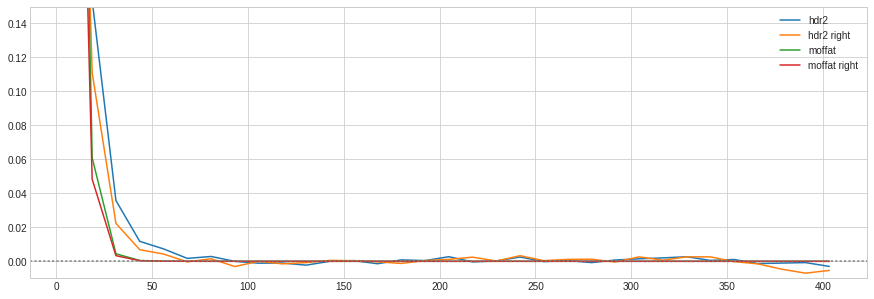

In [33]:
tmp = ascii.read("xi-hdr2.dat")
tmp2 = ascii.read("xi-hdr2-right.dat")
diff = np.diff(tmp["delta_r[kpc]"])[0]/2.
print(diff)
plt.figure(figsize=(15,5))
plt.plot(tmp["delta_r[kpc]"]+diff, (tmp["flux_biw"]-mid)*tmp2["flux_biw"][0]/tmp["flux_biw"][0], label="hdr2")
plt.plot(tmp2["delta_r[kpc]"]+diff, tmp2["flux_biw"]-mid2, label="hdr2 right")
#plt.plot(tmp["delta_r[kpc]"]+diff, tmp["ffss_biw"]-midffss, label="ffss 2019")
#plt.plot(tmp["delta_r[kpc]"], tmp["cal_biw"])
plt.plot(tmp["delta_r[kpc]"]+diff, tmp["moffat"], label="moffat")#*tmp["flux_biw"][0]/tmp["moffat"][0])
plt.plot(tmp2["delta_r[kpc]"]+diff, tmp2["moffat"], label="moffat right")#*tmp["flux_biw"][0]/tmp["moffat"][0])
#plt.plot(np.arange(0,distances[-2].value,1), Moffat1D.evaluate(np.arange(0,distances[-2].value,1), tmp["flux_biw"][0], 0, gamma=2.0*kpc_proper_per_deg(2.5).value[0]/3600., alpha=3.9))
plt.axhline(0, color="gray", linestyle=":")
plt.ylim(-0.01, 0.15)
plt.legend()
#plt.yscale("log")
tmp["flux_biw"][0], tmp["moffat"][0]